# Two Qubit CNOT Gate with Piccolo.jl

In [525]:
using Revise
using SparseArrays
using LinearAlgebra
using Piccolo
using Random; Random.seed!(1234);

## System Hamiltonian

The Hamiltonian for this two qubit system example is given by

$$
H(u(t)) = g \hat a^\dagger \hat a \hat b^\dagger \hat b + a_1(t) (\hat a + \hat a^\dagger) + i a_2(t) (\hat a - \hat a^\dagger) + a_3(t) (\hat b + \hat b^\dagger) + i a_4(t)(\hat b - \hat b^\dagger) 
$$

where $\hat a$ and $\hat b$ are the annihilation operators for the first and second qubit respectively, $g$ is the coupling strength, and $u_i(t)$ are the control functions.


In [2]:
function TwoQubitSystem(levels::Int)

    g_coupling = 0.1 # GHz (linear units)

    # annihilation operator for qubit 1 
    â = lift(annihilate(levels), 1, 2)

    # annihilation operator for qubit 2
    b̂ = lift(annihilate(levels), 2, 2);

    # drift Hamiltonian
    H_drift = 2π * g_coupling * â' * â * b̂' * b̂

    # drive Hamiltonians
    H_drives = [
        2π * (â + â'),
        2π * 1.0im * (â - â'),
        2π * (b̂ + b̂'),
        2π * 1.0im * (b̂ - b̂') 
    ]

    return QuantumSystem(H_drift, H_drives);
end

TwoQubitSystem (generic function with 1 method)

In [3]:
levels_per_qubit = 2
system = TwoQubitSystem(levels_per_qubit);

## CNOT Unitary Gate

The goal gate that we will be optimizing for is the CNOT gate defined as

$$
U_{CNOT} = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
$$


In [4]:
U_goal = [
    1 0 0 0;
    0 1 0 0;
    0 0 0 1;
    0 0 1 0
]; 

## Temporal Discretization Parameters

Here we will define the temporal discretization parameters for the control functions. We will use a total time of $T = 10$ and a time step of $\Delta t = 0.1$.

In [5]:
T = 15.0 # ns
N = 100
Δt = T / N;

## Pulse Constraints

Here we define bounds on the control as well as a constraint on the second derivative of the control that enforces smoothness of the pulse.

In [325]:
a_bound = 0.0175 # GHz
dda_bound = 0.2; # bound on second derivative of control, to ensure smoothness

## Defining The Problem

Here we define the problem using the `UnitarySmoothPulseProblem` which handles setting up a smoothness constrained pulse optimization problem for a unitary gate.

In [326]:
# setting maximum number of iterations 
max_iter = 100 

prob = UnitarySmoothPulseProblem(
    system,
    U_goal,
    N,
    Δt;
    a_bound=a_bound,
    dda_bound=dda_bound,
    max_iter=max_iter
)

applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(46) … MOI.VariableIndex(4411) MOI.VariableIndex(4456); MOI.VariableIndex(2) MOI.VariableIndex(47) … MOI.VariableIndex(4412) MOI.VariableIndex(4457); … ; MOI.VariableIndex(44) MOI.VariableIndex(89) … MOI.VariableIndex(4454) MOI.VariableIndex(4499); MOI.VariableIndex(45) MOI.VariableIndex(90) … MOI.VariableIndex(4455) MOI.VariableIndex(4500)], QuantumSystem{Float64}([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.6283185307179586], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [[0.0 0.0 6.283185307179586 0.0; 0.0 0.0 0.0 6.283185307179586; 6.283185307179586 0.0 0.0 0.0; 0.0 6.283185307179586 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 -0.0 0.0 0.0], [0.0 6.283185307179586 0.0 0.0; 6.283185307179586 0.0 0.0 0.0; 0.0 0.0 0.0 6.283185307179586; 0.0 0.0 6.283185307179586 0.0], [0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 0.0 

Here we plot the initial guess for the unitary and controls, which are stored as `Symbol`s, `:Ũ⃗` and `:a`, respectively. Note that the initial guess for the unitary is not random, it is in fact the geodesic path between the identity and the target unitary. This is not required for the optimizer to converge, but it can help speed up convergence.

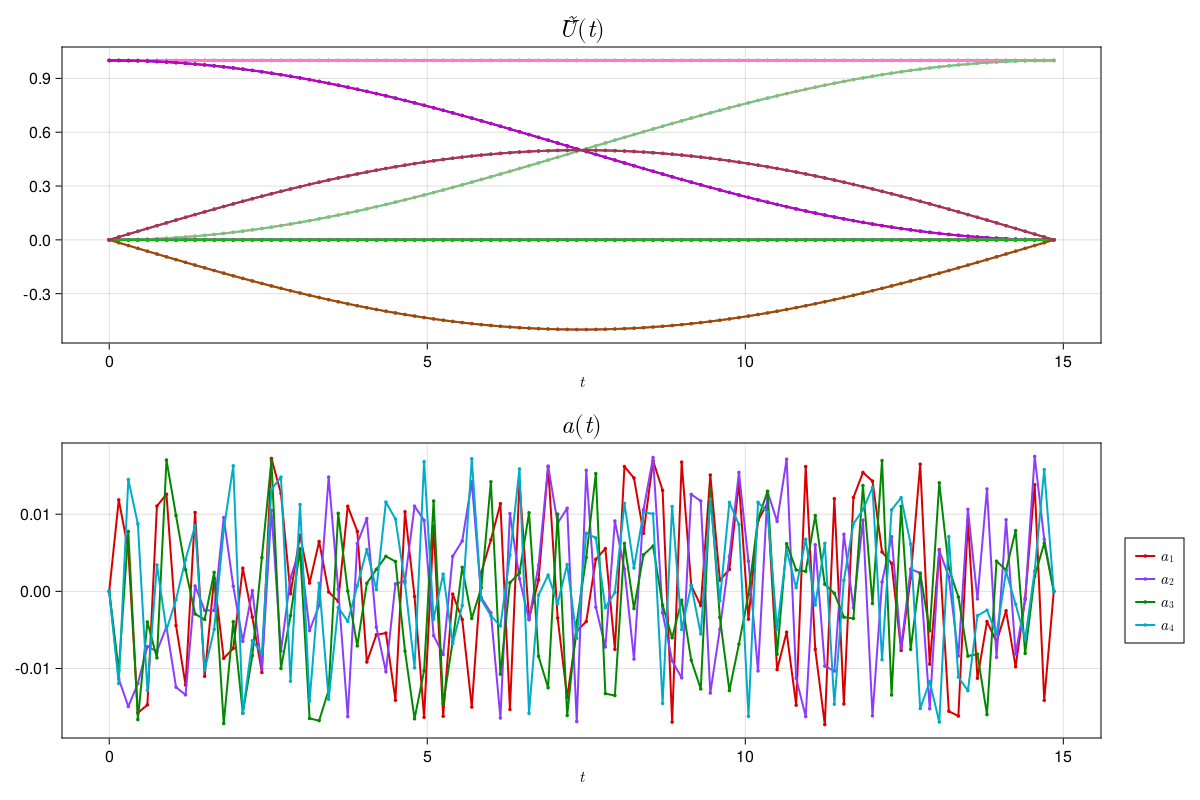

In [327]:
plot(prob.trajectory, [:Ũ⃗, :a]; ignored_labels=[:Ũ⃗])

Here we call the `solve!` method on the problem, which uses the interior point nonlinear solver IPOPT to optimize over the states and controls of the problem.

In [328]:
QuantumCollocation.solve!(prob)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.0.

Number of nonzeros in equality constraint Jacobian...:    64774
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    34296

Total number of variables............................:     4460
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      892
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4059
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.1660992e-04 1.10e-01 3.82e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  4.8053548e+01 3.84e-02 2.49e+01  -1.7 1.77e+00    -  1.00e+00 1.00e+00h  1


   2  1.6318089e+01 3.80e-02 2.59e+01  -1.7 6.45e+01    -  1.99e-02 2.03e-02f  1


   3  5.9281489e+00 3.27e-02 2.79e+01  -1.7 3.43e+00    -  4.50e-02 1.46e-01f  1


   4  4.0198076e+00 3.17e-02 2.71e+01  -1.7 2.02e+00   0.0 1.24e-01 2.94e-02f  1


   5  6.8121505e+00 2.99e-02 2.50e+01  -1.7 4.41e+00  -0.5 4.90e-02 7.73e-02h  1


   6  8.8270146e+00 2.84e-02 2.69e+01  -1.7 3.76e+00  -1.0 8.99e-02 7.51e-02h  1


   7  4.8151549e+00 2.81e-02 2.63e+01  -1.7 4.43e+00  -0.5 1.54e-02 2.46e-02f  1


   8  2.6046833e+00 1.91e-02 3.22e+01  -1.7 9.23e-01  -0.1 4.53e-02 3.26e-01f  1


   9  3.0216814e+01 1.85e-02 2.53e+01  -1.7 1.81e+00    -  1.61e-02 2.33e-01H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6320986e+01 1.70e-02 2.22e+01  -1.7 1.62e+00  -0.6 2.33e-02 1.23e-01f  1


  11  1.0433190e+00 1.83e-02 2.01e+01  -1.7 3.18e+00  -1.1 5.02e-02 9.56e-02f  1


  12  3.7520560e+00 1.64e-02 3.24e+01  -1.7 1.06e+00  -0.6 2.71e-01 1.36e-01h  1


  13  7.1755766e-01 1.62e-02 3.21e+01  -1.7 6.55e+00    -  2.42e-02 8.10e-03f  1


  14  7.6191630e-01 1.62e-02 1.78e+01  -1.7 5.71e+00    -  6.18e-03 4.82e-03f  3


  15  2.6193160e+00 1.54e-02 3.27e+01  -1.7 2.11e+00  -1.1 3.89e-02 4.91e-02h  1


  16  3.2842885e-01 1.53e-02 3.25e+01  -1.7 5.17e+00    -  1.15e-02 8.48e-03f  1


  17  1.3235485e+00 1.52e-02 1.75e+01  -1.7 6.07e+00    -  4.18e-03 5.35e-03h  3


  18  1.0544750e+01 9.31e-03 4.06e+01  -1.7 8.56e-01  -0.7 1.08e-01 4.68e-01h  1


  19  5.8806173e-01 7.47e-03 2.95e+01  -1.7 6.51e-01    -  2.84e-01 2.74e-01f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.3602203e+00 7.46e-03 2.10e+01  -1.7 2.89e+00  -1.2 7.53e-02 2.13e-02h  3


  21  6.0728512e+00 7.76e-03 3.44e+01  -1.7 1.11e+00  -0.7 2.23e-01 2.75e-01H  1


  22  3.1415927e+00 7.41e-03 3.21e+01  -1.7 9.98e-01    -  3.80e-02 6.76e-02f  1


  23  2.4062733e-01 7.40e-03 1.86e+01  -1.7 3.02e+00    -  2.96e-02 2.88e-02f  2


  24  6.2812489e-01 4.95e-03 4.40e+01  -1.7 3.33e-01  -0.3 1.81e-01 6.89e-01h  1


  25  7.7048527e-01 4.64e-03 1.95e+01  -1.7 1.14e+00    -  9.83e-02 7.27e-02f  2


  26  3.8113181e-01 2.60e-03 4.53e+01  -1.7 2.98e-01  -0.8 5.12e-01 4.73e-01f  1


  27  1.7051274e+00 2.01e-03 1.50e+01  -1.7 4.76e-01    -  1.36e-01 2.27e-01h  1


  28  1.2253839e+00 3.27e-03 3.66e+01  -1.7 2.56e-01  -0.4 5.18e-02 9.60e-01f  1


  29  7.3268140e-01 1.56e-03 1.57e+01  -1.7 2.65e-01    -  3.64e-01 5.63e-01f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.3600486e-01 1.42e-03 2.56e+00  -1.7 2.63e-01    -  8.79e-01 8.32e-01h  1


  31  1.2006527e+00 3.97e-04 5.17e-02  -1.7 8.14e-02    -  1.00e+00 1.00e+00f  1


  32  3.0443719e-01 3.67e-04 7.14e-01  -2.5 6.69e-02    -  8.15e-01 1.00e+00f  1


  33  2.0497122e-01 1.25e-04 4.51e-02  -2.5 3.33e-02  -0.8 1.00e+00 1.00e+00h  1


  34  1.8886400e-01 8.31e-06 3.44e-03  -2.5 8.81e-03  -0.4 1.00e+00 1.00e+00h  1


  35  1.0808773e-02 1.01e-04 2.29e-01  -3.8 2.99e-02  -0.9 8.75e-01 1.00e+00f  1


  36  1.4821200e-02 1.63e-05 5.40e-03  -3.8 1.30e-02  -0.5 1.00e+00 1.00e+00h  1


  37  3.0171257e-03 1.30e-05 2.42e-03  -3.8 1.66e-02  -0.9 1.00e+00 1.00e+00h  1


  38  5.3297997e-03 4.55e-06 6.43e-04  -3.8 1.67e-02  -1.4 1.00e+00 1.00e+00H  1


  39  3.8515500e-03 8.26e-07 3.50e-04  -4.0 3.41e-03  -1.0 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.5661219e-03 1.40e-05 3.83e-04  -4.0 1.06e-02  -1.5 1.00e+00 1.00e+00h  1


  41  3.5264174e-03 1.82e-06 3.55e-04  -4.0 3.82e-03  -1.0 1.00e+00 1.00e+00h  1


  42  2.6227752e-03 2.70e-05 6.27e-04  -4.0 1.46e-02  -1.5 1.00e+00 1.00e+00h  1


  43  3.1433436e-03 4.42e-05 5.00e+01  -4.0 5.65e-02  -2.0 1.00e+00 2.50e-01h  3


  44  4.2819879e-03 4.25e-05 2.50e+01  -4.0 2.25e-02  -1.6 1.00e+00 5.00e-01h  2


  45  2.5634496e-03 2.36e-05 1.39e+01  -4.0 9.01e-03  -0.2 1.00e+00 4.46e-01h  2


  46  2.1961037e-03 2.56e-06 1.56e-01  -4.0 6.21e-03  -0.7 1.00e+00 1.00e+00h  1


  47  2.9447695e-03 7.95e-07 5.51e-04  -4.0 6.34e-03  -1.2 1.00e+00 1.00e+00H  1


  48  2.0755490e-03 4.16e-05 1.65e-03  -4.0 1.58e-02  -1.7 1.00e+00 1.00e+00H  1


  49  3.2484932e-03 3.92e-05 5.00e+01  -4.0 3.87e-02  -2.1 1.00e+00 2.50e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.1325561e-03 4.40e-05 2.50e+01  -4.0 2.81e-02  -1.7 1.00e+00 5.00e-01h  2


  51  2.1109822e-03 3.45e-05 3.06e+01  -4.0 3.74e-02  -0.4 1.00e+00 2.27e-01h  3


  52  4.6183758e-03 2.64e-05 2.70e+01  -4.0 1.90e-02  -0.9 1.00e+00 2.50e-01h  3


  53  5.0219509e-03 1.55e-06 2.77e-01  -4.0 3.21e-03   0.5 1.00e+00 1.00e+00h  1


  54  4.0090994e-03 6.88e-07 2.70e-03  -4.0 2.81e-03  -0.0 1.00e+00 1.00e+00h  1


  55  2.8759038e-03 5.26e-07 9.71e-04  -4.0 3.03e-03  -0.5 1.00e+00 1.00e+00h  1


  56  2.4163503e-03 1.02e-06 3.56e-04  -4.0 3.34e-03  -1.0 1.00e+00 1.00e+00h  1


  57  2.4061545e-03 6.61e-06 4.99e+01  -4.0 8.29e-03  -1.4 1.00e+00 1.00e+00h  1


  58  2.8009172e-03 4.76e-06 2.50e+01  -4.0 1.21e-02  -1.9 1.00e+00 5.00e-01h  2


  59  2.6062140e-03 7.79e-07 2.65e-01  -4.0 3.19e-03   0.3 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.6690502e-03 2.75e-07 1.09e-03  -4.0 1.61e-03  -0.2 1.00e+00 1.00e+00h  1


  61  2.4367323e-03 2.03e-07 4.08e-04  -4.0 1.82e-03  -0.6 1.00e+00 1.00e+00h  1


  62  2.0635821e-03 1.25e-06 2.97e-04  -4.0 3.77e-03  -1.1 1.00e+00 1.00e+00h  1


  63  1.8323832e-03 3.91e-06 6.07e-04  -4.0 1.06e-02  -1.6 1.00e+00 1.00e+00H  1


  64  2.2240024e-03 2.95e-06 4.99e+01  -4.0 2.76e-02  -2.1 1.00e+00 2.50e-01h  3


  65  2.5057659e-03 7.46e-05 2.50e+01  -4.0 5.24e-02  -2.6 1.00e+00 5.00e-01h  2


  66  2.5411631e-03 3.76e-05 3.74e+01  -4.0 1.41e-02  -0.3 1.00e+00 5.00e-01h  2


  67  2.2311936e-03 2.82e-05 2.18e+01  -4.0 9.77e-03  -0.8 1.00e+00 2.50e-01h  3


  68  2.0268088e-03 2.12e-05 3.35e+01  -4.0 1.52e-02  -0.4 1.00e+00 2.50e-01h  3


  69  3.2681158e-03 1.58e-05 2.48e+01  -4.0 1.40e-02  -0.9 1.00e+00 2.50e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.8806885e-03 6.25e-07 1.86e-01  -4.0 2.76e-03   0.5 1.00e+00 1.00e+00h  1


  71  3.2503347e-03 2.79e-07 1.81e-03  -4.0 1.82e-03  -0.0 1.00e+00 1.00e+00h  1


  72  2.4128748e-03 4.40e-07 8.81e-04  -4.0 2.65e-03  -0.5 1.00e+00 1.00e+00h  1


  73  2.0314828e-03 5.14e-07 3.17e-04  -4.0 2.87e-03  -1.0 1.00e+00 1.00e+00h  1


  74  2.0593830e-03 3.29e-06 4.99e+01  -4.0 5.94e-03  -1.4 1.00e+00 1.00e+00h  1


  75  4.8837102e-03 4.88e-08 4.99e+01  -4.0 7.35e-03  -1.9 1.00e+00 1.00e+00H  1


  76  4.3047785e-03 1.67e-07 2.33e-01  -4.0 1.30e-03   1.2 1.00e+00 1.00e+00h  1


  77  4.0162930e-03 2.14e-08 3.84e-03  -4.0 6.85e-04   0.7 1.00e+00 1.00e+00h  1


  78  3.4287205e-03 9.61e-08 2.05e-03  -4.0 1.10e-03   0.3 1.00e+00 1.00e+00h  1


  79  2.6498519e-03 3.17e-07 1.22e-03  -4.0 1.96e-03  -0.2 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.1189739e-03 4.22e-07 4.99e-04  -4.0 2.41e-03  -0.7 1.00e+00 1.00e+00h  1


  81  1.7715372e-03 8.67e-07 2.08e-04  -4.0 3.01e-03  -1.2 1.00e+00 1.00e+00h  1


  82  1.7459643e-03 2.21e-06 5.09e-04  -4.0 7.77e-03  -1.6 1.00e+00 1.00e+00H  1


  83  1.9920762e-03 1.55e-06 4.98e+01  -4.0 1.89e-02  -2.1 1.00e+00 2.50e-01h  3


  84  2.1830813e-03 1.69e-05 2.49e+01  -4.0 2.56e-02  -2.6 1.00e+00 5.00e-01h  2


  85  1.6592629e-03 1.27e-05 1.87e+01  -4.0 9.64e-03  -0.4 1.00e+00 2.50e-01h  3


  86  2.2160977e-03 3.01e-07 7.77e-02  -4.0 1.42e-03   0.1 1.00e+00 1.00e+00h  1


  87  2.0276137e-03 8.67e-08 4.43e-04  -4.0 1.14e-03  -0.4 1.00e+00 1.00e+00h  1


  88  1.8901512e-03 1.84e-07 2.06e-04  -4.0 1.59e-03  -0.9 1.00e+00 1.00e+00h  1


  89  1.6644585e-03 1.14e-06 4.98e+01  -4.0 3.43e-03  -1.4 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.1458534e-03 2.48e-08 4.98e+01  -4.0 5.52e-03  -1.8 1.00e+00 1.00e+00H  1


  91  3.7675160e-03 9.14e-08 1.72e-01  -4.0 9.57e-04   1.3 1.00e+00 1.00e+00h  1


  92  3.5112290e-03 3.07e-08 4.47e-03  -4.0 6.81e-04   0.8 1.00e+00 1.00e+00h  1


  93  3.0715699e-03 6.27e-08 1.93e-03  -4.0 8.85e-04   0.3 1.00e+00 1.00e+00h  1


  94  2.4651349e-03 2.05e-07 1.20e-03  -4.0 1.65e-03  -0.1 1.00e+00 1.00e+00h  1


  95  2.0020938e-03 3.09e-07 5.05e-04  -4.0 2.08e-03  -0.6 1.00e+00 1.00e+00h  1


  96  1.7716053e-03 4.10e-07 1.89e-04  -4.0 2.34e-03  -1.1 1.00e+00 1.00e+00h  1


  97  1.8218620e-03 5.17e-07 2.43e-04  -4.0 4.62e-03  -1.6 1.00e+00 1.00e+00H  1


  98  1.6086072e-03 5.75e-07 4.98e+01  -4.0 1.12e-02  -2.0 1.00e+00 2.50e-01h  3


  99  1.8543296e-03 9.43e-07 1.24e+01  -4.0 1.00e-02  -2.5 1.00e+00 2.50e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8558023e-03 6.71e-08 3.96e-02  -4.0 1.12e-03  -0.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   1.8558022950318691e-03    1.8558022950318691e-03
Dual infeasibility......:   3.9619938642079626e-02    3.9619938642079626e-02
Constraint violation....:   6.7147281831991812e-08    6.7147281831991812e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0006070296964732e-04    1.0006070296964732e-04
Overall NLP error.......:   3.9619938642079626e-02    3.9619938642079626e-02


Number of objective function evaluations             = 181
Number of objective gradient evaluations             = 101
Number of equality constraint evaluations            = 181
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

Let's now calculate the fidelity of the optimized unitary with the target unitary, via rollout with the full matrix exponential, this is achieved via the `unitary_fidelity` method.

In [329]:
fid = unitary_fidelity(prob.trajectory, system)
println("Fidelity: $fid")

Fidelity: 0.9999963797998204


And now let's plot the final solution for the unitary and controls.

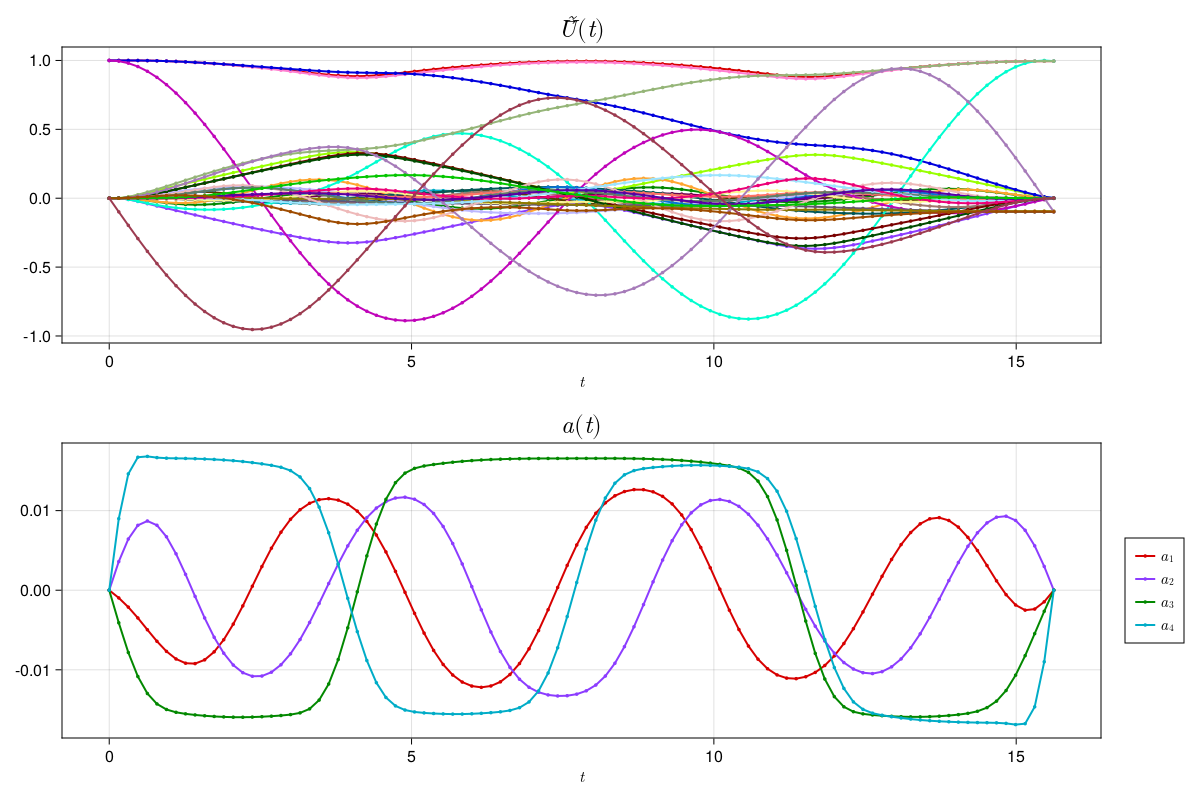

In [330]:
plot(prob.trajectory, [:Ũ⃗, :a]; ignored_labels=[:Ũ⃗])

## Minimum Time CNOT

Now let's see how fast we can make this pulse, by setting up and solving a minimum time problem, using the solution we just found.

We will add an objective term to the problem that penalizes the total time, as well as constraint on the final state of the form

$$
\mathcal{F}(U(T)) \geq \mathcal{F}_{\text{target}}.
$$

This enforce that the final fidelity does not decrease below the threshold $\mathcal{F}_{\text{target}}$, while also allowing the phase to shift.

In [331]:
# final fidelity constraint
min_fidelity = 0.9999

# minimum time objective weight
D = 1000.0

# define the problem
mintime_prob = UnitaryMinimumTimeProblem(prob; D=D, final_fidelity=min_fidelity);

applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint


In [332]:
# solving the problem
QuantumCollocation.solve!(mintime_prob; max_iter=max_iter)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.0.

Number of nonzeros in equality constraint Jacobian...:    64774
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:    34332

Total number of variables............................:     4460
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      892
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4059
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5779579e+02 6.71e-08 5.11e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  1.4861668e+02 1.25e-02 5.02e+00  -1.7 1.01e+00    -  8.58e-01 8.65e-01f  1


   2  1.4185050e+02 4.80e-03 1.75e+00  -1.7 6.79e-01    -  1.00e+00 1.00e+00h  1


   3  1.4772381e+02 2.14e-03 5.17e+00  -1.7 4.23e-01    -  1.00e+00 6.87e-01h  1


   4  1.5299977e+02 1.50e-03 5.53e+00  -1.7 2.23e-01    -  1.00e+00 1.00e+00h  1


   5  1.5172398e+02 7.68e-04 5.63e+01  -1.7 1.41e-01    -  8.23e-01 4.55e-01h  1


   6  1.5317778e+02 8.42e-04 1.10e+01  -1.7 8.06e-02    -  1.00e+00 1.00e+00h  1


   7  1.5198749e+02 4.79e-04 2.62e+02  -1.7 8.09e-02    -  1.00e+00 5.12e-01h  1


   8  1.5210960e+02 4.82e-04 1.29e+02  -1.7 7.99e-01    -  2.28e-01 2.65e-02h  4


   9  1.5296445e+02 9.09e-05 1.32e+01  -1.7 3.87e-02   0.0 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5335560e+02 8.30e-05 6.33e+02  -1.7 7.03e-02  -0.5 1.00e+00 2.38e-01h  3


  11  1.5413840e+02 5.09e-05 2.02e+01  -1.7 2.61e-02  -0.1 1.00e+00 1.00e+00h  1


  12  1.5444095e+02 4.92e-05 2.06e+02  -1.7 9.53e-02  -0.5 1.00e+00 1.25e-01h  4


  13  1.5540690e+02 2.38e-05 6.78e+00  -1.7 1.75e-02  -0.1 1.00e+00 1.00e+00h  1


  14  1.5588223e+02 2.45e-05 2.68e+01  -1.7 2.61e-02  -0.6 1.00e+00 5.00e-01h  2


  15  1.5603613e+02 2.37e-05 5.11e+01  -1.7 4.49e-02  -1.1 1.00e+00 1.25e-01h  4


  16  1.5674663e+02 1.27e-05 6.18e-01  -1.7 1.69e-02  -0.6 1.00e+00 1.00e+00h  1


  17  1.5703342e+02 2.51e-06 7.55e-01  -1.7 7.39e-03  -1.1 1.00e+00 1.00e+00h  1


  18  1.5710826e+02 3.71e-06 1.40e-02  -1.7 6.69e-03  -1.6 1.00e+00 1.00e+00h  1


  19  1.5455655e+02 1.65e-04 4.07e+02  -3.8 4.26e-02  -2.1 7.45e-01 1.00e+00f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.5428193e+02 1.88e-05 1.23e+02  -3.8 1.42e-02   0.2 9.35e-01 1.00e+00h  1


  21  1.5424532e+02 3.57e-07 1.47e+02  -3.8 1.78e-03   1.5 2.63e-01 1.00e+00h  1


  22  1.5410227e+02 4.60e-07 1.36e-01  -3.8 4.85e-03   1.0 1.00e+00 1.00e+00f  1


  23  1.5378070e+02 2.82e-06 6.07e+00  -3.8 1.25e-02   0.5 1.00e+00 7.95e-01f  1


  24  1.5299089e+02 1.62e-05 2.10e+01  -3.8 2.47e-02   0.1 1.00e+00 7.88e-01f  1


  25  1.5192788e+02 5.44e-05 4.99e+01  -3.8 3.32e-02  -0.4 1.00e+00 6.04e-01f  1


  26  1.5151060e+02 2.05e-05 5.00e+00  -3.8 1.77e-02   0.0 1.00e+00 1.00e+00f  1


  27  1.5135807e+02 3.14e-06 1.09e-01  -3.8 6.07e-03   0.4 1.00e+00 1.00e+00h  1


  28  1.5082760e+02 3.89e-05 4.28e-01  -3.8 1.96e-02  -0.0 1.00e+00 1.00e+00f  1


  29  1.5060811e+02 4.54e-06 9.77e-02  -3.8 8.53e-03   0.4 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5008749e+02 4.34e-05 3.35e+00  -3.8 2.91e-02  -0.1 1.00e+00 7.84e-01f  1


  31  1.4981394e+02 5.75e-06 8.24e-02  -3.8 1.15e-02   0.3 1.00e+00 1.00e+00f  1


  32  1.4946982e+02 1.44e-05 5.14e-01  -3.8 3.88e-02  -0.1 1.00e+00 4.50e-01h  1


  33  1.4893721e+02 1.27e-04 6.96e+00  -3.8 1.62e-01  -0.6 7.06e-01 2.33e-01f  1


  34  1.4834711e+02 4.48e-05 1.07e+01  -3.8 5.49e-02  -0.2 1.00e+00 7.76e-01f  1


  35  1.4817281e+02 4.10e-05 1.43e+02  -3.8 5.69e-02  -0.7 1.00e+00 1.56e-01f  1


  36  1.4777416e+02 2.24e-05 1.38e+00  -3.8 1.97e-02  -0.2 1.00e+00 1.00e+00f  1


  37  1.4759479e+02 1.81e-05 9.55e+01  -3.8 7.65e-02  -0.7 1.00e+00 4.84e-01h  1


  38  1.4754940e+02 3.28e-05 9.30e+01  -3.8 6.99e-01  -1.2 1.04e-01 5.02e-02f  1


  39  1.4741058e+02 3.38e-05 5.27e+01  -3.8 8.07e-02  -0.8 1.00e+00 6.11e-01f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.4733036e+02 6.79e-05 4.91e+01  -3.8 8.00e-01  -1.2 7.79e-02 6.79e-02f  1


  41  1.4711451e+02 4.95e-05 1.02e+01  -3.8 6.16e-02  -0.8 4.50e-01 1.00e+00f  1


  42  1.4700823e+02 6.53e-05 3.34e+00  -3.8 2.00e-01  -1.3 2.97e-01 1.23e-01h  1


  43  1.4680896e+02 7.53e-05 9.93e-01  -3.8 5.58e-02  -0.9 1.00e+00 7.30e-01f  1


  44  1.4649850e+02 2.70e-04 1.12e+00  -3.8 4.10e-01  -1.3 1.95e-01 2.36e-01f  1


  45  1.4619027e+02 1.99e-04 2.06e+00  -3.8 9.34e-02  -0.9 6.04e-01 6.85e-01f  1


  46  1.4592082e+02 3.58e-04 1.30e+00  -3.8 2.12e-01  -1.4 1.86e-01 1.63e-01f  1


  47  1.4565860e+02 2.35e-04 1.65e+00  -3.8 1.04e-01  -1.0 7.46e-01 5.28e-01f  1


  48  1.4547170e+02 2.08e-04 3.61e-01  -3.8 1.97e-01  -1.4 3.85e-01 2.16e-01f  1


  49  1.4526987e+02 4.99e-05 2.79e+00  -3.8 4.77e-02  -1.0 1.00e+00 8.73e-01f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.4513755e+02 1.02e-04 2.86e+00  -3.8 1.36e-01  -1.5 4.09e-01 5.25e-01f  1


  51  1.4505241e+02 1.99e-05 1.71e+00  -3.8 6.16e-02  -1.1 9.28e-01 1.00e+00f  1


  52  1.4494086e+02 8.46e-05 6.43e-01  -3.8 3.29e-01  -1.6 4.75e-01 4.35e-01h  1


  53  1.4492067e+02 7.92e-05 1.03e+01  -3.8 2.11e-01  -2.0 4.26e-01 8.53e-02f  1


  54  1.4485474e+02 3.64e-05 1.73e+00  -3.8 7.77e-02  -1.6 7.74e-01 8.34e-01f  1


  55  1.4482857e+02 7.52e-05 1.31e+00  -3.8 1.12e-01  -2.1 9.93e-01 7.82e-01f  1


  56  1.4479798e+02 1.73e-05 3.57e-02  -3.8 7.81e-02  -1.7 9.96e-01 1.00e+00f  1


  57  1.4479529e+02 2.09e-06 1.83e-02  -3.8 2.49e-02  -1.2 1.00e+00 1.00e+00h  1


  58  1.4472884e+02 3.10e-05 4.20e-01  -3.8 1.51e-01  -1.7 1.00e+00 1.00e+00H  1


  59  1.4471529e+02 1.22e-05 1.99e-01  -3.8 5.63e-02  -1.3 1.00e+00 8.79e-01h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.4470810e+02 8.17e-05 2.41e-01  -3.8 7.77e-02  -1.8 8.18e-01 1.00e+00f  1


  61  1.4468369e+02 2.92e-05 6.25e-03  -3.8 2.58e-02  -1.3 1.00e+00 1.00e+00h  1


  62  1.4462629e+02 8.28e-05 4.77e-01  -3.8 1.27e-01  -1.8 7.95e-01 9.88e-01H  1


  63  1.4459513e+02 7.48e-05 6.34e-01  -3.8 1.34e-01  -2.3 7.01e-01 6.41e-01f  1


  64  1.4459331e+02 7.12e-05 9.05e-01  -3.8 5.16e-01  -2.8 1.73e-01 7.78e-02f  2


  65  1.4459474e+02 7.78e-05 1.60e+00  -3.8 2.39e-01  -2.3 5.42e-01 2.94e-01h  2


  66  1.4460220e+02 5.57e-05 2.64e-02  -3.8 7.54e-02  -1.9 1.00e+00 1.00e+00h  1


  67  1.4460120e+02 5.67e-05 8.62e-01  -3.8 8.01e-01    -  1.70e-01 2.13e-02h  4


  68  1.4460289e+02 5.93e-05 5.21e-01  -3.8 1.77e+00  -2.4 4.66e-02 1.04e-02h  4


  69  1.4458605e+02 4.04e-05 3.14e+00  -3.8 7.70e-02  -2.0 6.95e-01 3.82e-01H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.4458632e+02 4.16e-05 1.70e+00  -3.8 3.64e-01  -2.4 1.34e-01 5.20e-02f  3


  71  1.4458872e+02 4.64e-05 4.41e-01  -3.8 2.43e-01  -2.0 2.35e-01 1.45e-01h  2


  72  1.4459078e+02 5.13e-05 1.04e-01  -3.8 4.05e-01  -2.5 1.33e-01 8.40e-02h  2


  73  1.4459000e+02 3.02e-05 1.60e-02  -3.8 8.35e-02  -2.1 1.00e+00 1.00e+00H  1


  74  1.4458364e+02 2.68e-05 1.45e+00  -3.8 7.78e-01    -  1.65e-01 8.36e-02h  2


  75  1.4457995e+02 6.17e-06 1.34e-02  -3.8 2.42e-02  -1.6 1.00e+00 1.00e+00h  1


  76  1.4457914e+02 8.60e-06 7.91e-01  -3.8 6.39e-01    -  1.94e-01 2.79e-02h  4


  77  1.4454878e+02 1.34e-04 7.72e-02  -3.8 1.13e-01  -2.1 1.00e+00 1.00e+00H  1


  78  1.4455068e+02 1.08e-04 3.25e+00  -3.8 3.84e-01    -  2.51e-01 1.10e-01h  2


  79  1.4455441e+02 7.50e-05 2.52e+00  -3.8 2.88e+00  -2.6 1.75e-02 2.47e-02h  2


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.4456434e+02 2.78e-05 3.61e+00  -3.8 1.24e-01  -2.2 6.85e-01 4.31e-01h  2


  81  1.4456578e+02 3.07e-05 4.37e+00  -3.8 1.02e+00  -2.6 9.62e-02 3.76e-02h  3


  82  1.4456739e+02 3.19e-05 5.86e+00  -3.8 1.72e+00  -2.2 3.90e-02 9.22e-03h  4


  83  1.4457559e+02 1.78e-05 3.08e-02  -3.8 5.40e-02  -1.8 1.00e+00 1.00e+00H  1


  84  1.4454517e+02 5.23e-05 7.95e-02  -3.8 1.10e-01  -2.3 1.00e+00 1.00e+00H  1


  85  1.4454448e+02 3.84e-05 1.97e+00  -3.8 4.74e-01  -2.7 2.38e-01 9.99e-02h  2


  86  1.4454581e+02 3.14e-05 2.92e+00  -3.8 1.24e+00  -2.3 6.24e-02 3.88e-02h  2


  87  1.4453196e+02 1.97e-05 1.41e-01  -3.8 1.18e-01  -1.9 1.00e+00 9.73e-01H  1


  88  1.4453216e+02 2.04e-05 6.01e+00  -3.8 2.09e-01    -  5.47e-01 2.36e-01f  2


  89  1.4453113e+02 2.22e-05 2.20e+01  -3.8 4.27e-01  -2.4 2.84e-01 4.60e-02h  4


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.4453469e+02 3.12e-05 8.89e+00  -3.8 1.01e-01  -1.9 1.00e+00 5.00e-01h  2


  91  1.4445387e+02 6.20e-05 2.39e-02  -3.8 1.87e-01  -2.4 1.00e+00 1.00e+00H  1


  92  1.4448910e+02 5.54e-05 2.16e-01  -3.8 6.77e-02  -2.0 1.00e+00 1.00e+00h  1


  93  1.4448148e+02 6.38e-05 8.43e+00  -3.8 6.03e-01    -  1.79e-01 7.56e-02h  2


  94  1.4448273e+02 6.54e-05 1.61e+01  -3.8 5.51e-01    -  2.25e-01 6.41e-02h  3


  95  1.4448608e+02 6.50e-05 2.15e+01  -3.8 8.03e-01  -2.5 1.12e-01 2.57e-02h  4


  96  1.4451321e+02 5.33e-05 4.05e-01  -3.8 9.57e-02  -2.0 1.00e+00 1.00e+00H  1


  97  1.4449238e+02 4.93e-05 7.07e+00  -3.8 7.37e-01  -2.5 1.74e-01 5.66e-02h  1


  98  1.4450323e+02 3.06e-05 7.73e+00  -3.8 9.49e-02  -2.1 2.74e-01 3.87e-01f  2


  99  1.4449166e+02 3.42e-05 2.99e+00  -3.8 1.61e-01  -2.6 6.01e-01 3.19e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4448513e+02 3.86e-07 5.06e-03  -3.8 9.43e-03  -1.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   1.4448512957042958e+01    1.4448512957042956e+02
Dual infeasibility......:   5.0602452815662119e-03    5.0602452815662120e-02
Constraint violation....:   3.8649221867879946e-07    3.8649221867879946e-07
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.9686788290781070e-04    1.9686788290781067e-03
Overall NLP error.......:   5.0602452815662119e-03    5.0602452815662120e-02


Number of objective function evaluations             = 219
Number of objective gradient evaluations             = 101
Number of equality constraint evaluations            = 219
Number of ine

In [333]:
mintime_final_fidelity = unitary_fidelity(mintime_prob.trajectory, system)
println("Fidelity: $mintime_final_fidelity")

Fidelity: 0.9999001638815374


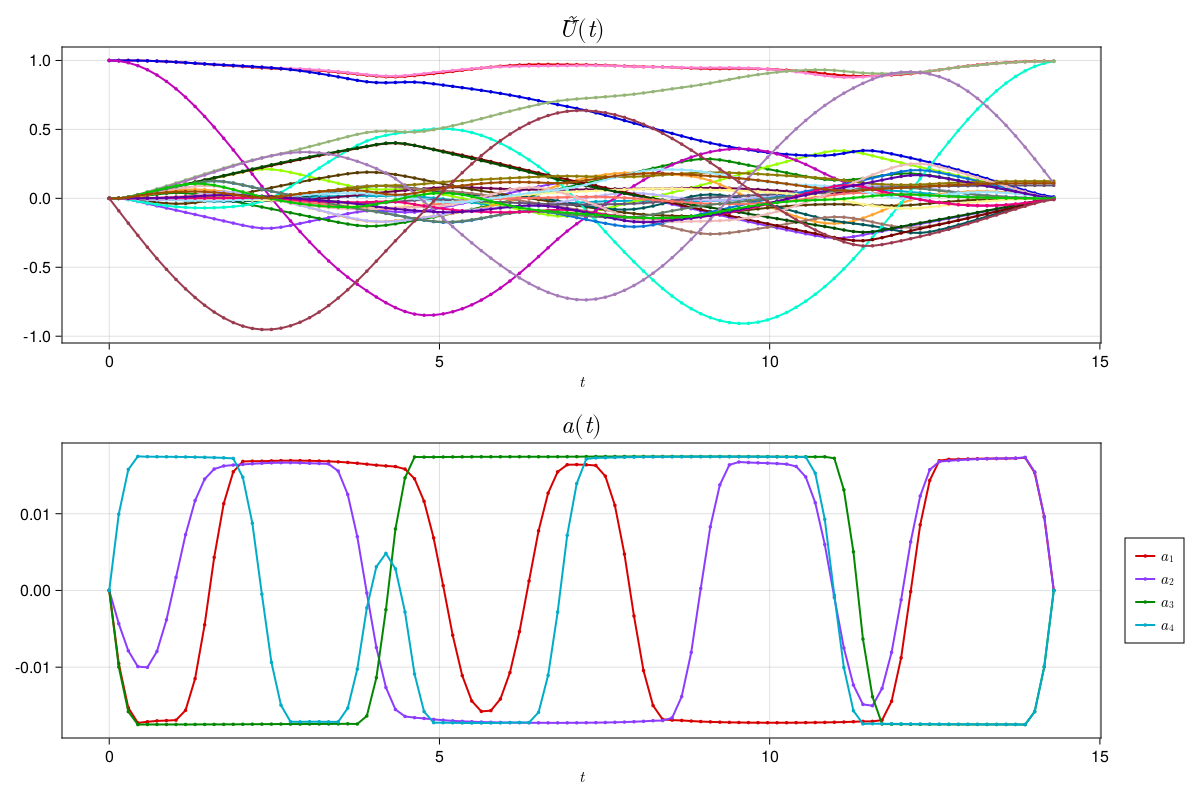

In [334]:
plot(mintime_prob.trajectory, [:Ũ⃗, :a]; ignored_labels=[:Ũ⃗])

In [335]:
original_duration = times(prob.trajectory)[end]
mintime_duration = times(mintime_prob.trajectory)[end]
println("Original Duration: $original_duration ns")
println("Minimum Duration:  $mintime_duration ns")

Original Duration: 15.621599547215254 ns
Minimum Duration:  14.301729737107545 ns


## Model Mistmatch and Iterative Learning Control

Now let's imagine that our goal is to test this pulse on an experimental system where we anticipate some hamiltonian errors. First we will define some states on this system using the `cavity_state` function to create states $\ket{g}$, $\ket{e}$ for individual qubits, and $\ket{gg}$, $\ket{ge}$, $\ket{eg}$, and $\ket{ee}$ on the combined two qubit system.

In [788]:
experimental_levels = 2

# define quantum ground state |g⟩
g = cavity_state(0, experimental_levels)

# define quantum excited state |e⟩
e = cavity_state(1, experimental_levels)

# define quantum states |gg⟩, |ge⟩, |eg⟩, |ee⟩
gg = g ⊗ g
ge = g ⊗ e
eg = e ⊗ g
ee = e ⊗ e;

In [875]:
unitary_fidelity_measurement = Ũ⃗ -> begin
    U_experiment = iso_vec_to_operator(Ũ⃗)
    return [unitary_fidelity(U_experiment, U_goal)]
end

experimental_initial_states = [
    gg,
    ge,
    eg,
    ee,
    (eg + ge) / √2,
    (gg + ee) / √2,
    (ge - im * eg) / √2,
    (ge - ee) / √2,

]

measurement = Ũ⃗ -> begin
    U_experiment = iso_vec_to_operator(Ũ⃗)
    return [fidelity(U_experiment * ψ, U_goal * ψ) for ψ ∈ rollout_states]
end


σ = 0.008

X_error = σ * randn() 
Y_error = σ * randn() 
Z_error = σ * randn() 


X_error = 0.003 
Y_error = -0.008
Z_error = 0.006 



H_error = -1.0im * (
    X_error * (GATES[:X] ⊗ GATES[:I] + GATES[:I] ⊗ GATES[:X]) +
    Y_error * (GATES[:Y] ⊗ GATES[:I] + GATES[:I] ⊗ GATES[:Y]) +
    Z_error * (GATES[:Z] ⊗ GATES[:I] + GATES[:I] ⊗ GATES[:Z])
) 
G_error = iso(H_error)


# define the measurement times
τs = [prob.trajectory.T]
# τs = [2:prob.trajectory.T...]
# τs = [50, 75, 85, 90, 95, prob.trajectory.T]

# define initial unitary
U_init = I(4) 

# define the simulation experiment
experiment = QuantumSimulationExperiment(
    system,
    operator_to_iso_vec(U_init),
    measurement,
    τs;
    unitary=true,
    G_error_term=G_error
);

# define the simulation experiment
unitary_fidelity_experiment = QuantumSimulationExperiment(
    system,
    operator_to_iso_vec(U_init),
    unitary_fidelity_measurement,
    τs;
    unitary=true,
    G_error_term=G_error
);



Here we define the reference trajectory and measure the unitary fidelity on the target system

In [876]:
goal_traj = prob.trajectory
# goal_traj = mintime_prob.trajectory

println("unitary fidelity = ", unitary_fidelity_experiment(goal_traj.a, goal_traj.Δt).ys[end][end])

unitary fidelity = 0.9860005197899032


Below we define the objective and optimizer -- backtracking line search -- for the ILC problem.

In [958]:
g_ref = measurement 
y_goal = g_ref(goal_traj[end].Ũ⃗) 
J(ŷ) = norm(ŷ - y_goal, 1)
α = 0.5^11
optimizer = BacktrackingLineSearch(J; α=α, verbose=false);

Here we define the ILC problem and then solve it.

In [962]:
ILC_max_iter = 100

ILC_prob = ILCProblem(
    goal_traj, 
    prob.system, 
    prob.integrators,
    # fidelities_experiment, 
    experiment,
    optimizer;
    g_ref=g_ref,
    max_iter=ILC_max_iter,
    Qf=400.0,
)

solve!(ILC_prob; manifold_projection=true);

Setting up dynamic QP...
building constraint matrix for a
building constraint matrix for dda


building constraint matrix for Δt
Building initial and final constraint matrices...
Building initial constraint matrix for Ũ⃗...
Building initial constraint matrix for a...
Building final constraint matrix for a...

Iteration 1


    J(Aⁱ) = 0.1673413833420403




Iteration 2


    J(Aⁱ) = 0.16679249211838731




Iteration 3


    J(Aⁱ) = 0.16527007056022391




Iteration 4


    J(Aⁱ) = 0.16375805693635914




Iteration 5


    J(Aⁱ) = 0.16227650340763267




Iteration 6


    J(Aⁱ) = 0.16081338374858245




Iteration 7


    J(Aⁱ) = 0.15936896646972165




Iteration 8


    J(Aⁱ) = 0.1579402399828429




Iteration 9


    J(Aⁱ) = 0.1565290895188679




Iteration 10


    J(Aⁱ) = 0.15513939917998687




Iteration 11


    J(Aⁱ) = 0.15375136839087378




Iteration 12


    J(Aⁱ) = 0.15235174319408684




Iteration 13


    J(Aⁱ) = 0.15095606256937044




Iteration 14


    J(Aⁱ) = 0.14956924238127312




Iteration 15


    J(Aⁱ) = 0.148202220484693




Iteration 16


    J(Aⁱ) = 0.1468630758077092




Iteration 17


    J(Aⁱ) = 0.14556498489012004




Iteration 18


    J(Aⁱ) = 0.14429530056725537




Iteration 19


    J(Aⁱ) = 0.14305205989380299




Iteration 20


    J(Aⁱ) = 0.14183457066227212




Iteration 21


    J(Aⁱ) = 0.14064294934620547




Iteration 22


    J(Aⁱ) = 0.1394773051659547




Iteration 23


    J(Aⁱ) = 0.13833823714201798




Iteration 24


    J(Aⁱ) = 0.1372253280469733




Iteration 25


    J(Aⁱ) = 0.13613869699275327




Iteration 26


    J(Aⁱ) = 0.13509289728942964




Iteration 27


    J(Aⁱ) = 0.1340710008806829




Iteration 28


    J(Aⁱ) = 0.13307288045143661




Iteration 29


    J(Aⁱ) = 0.13209819575754922




Iteration 30


    J(Aⁱ) = 0.13114542446037591




Iteration 31


    J(Aⁱ) = 0.13021391174579877




Iteration 32


    J(Aⁱ) = 0.12930448781595716




Iteration 33


    J(Aⁱ) = 0.1284264368470791




Iteration 34


    J(Aⁱ) = 0.1275792224000155




Iteration 35


    J(Aⁱ) = 0.12675827129588746




Iteration 36


    J(Aⁱ) = 0.12595804545429512




Iteration 37


    J(Aⁱ) = 0.12517810262563178




Iteration 38


    J(Aⁱ) = 0.12441640087284567




Iteration 39


    J(Aⁱ) = 0.12367477778377334




Iteration 40


    J(Aⁱ) = 0.12295265260616695




Iteration 41


    J(Aⁱ) = 0.12224660331877713




Iteration 42


    J(Aⁱ) = 0.12155570837803176




Iteration 43


    J(Aⁱ) = 0.12088424665080932




Iteration 44


    J(Aⁱ) = 0.12022993431424356




Iteration 45


    J(Aⁱ) = 0.11959649904863956




Iteration 46


    J(Aⁱ) = 0.11898194737803014




Iteration 47


    J(Aⁱ) = 0.1183859537159967




Iteration 48


    J(Aⁱ) = 0.1178096763940295




Iteration 49


    J(Aⁱ) = 0.11725144341412086




Iteration 50


    J(Aⁱ) = 0.11671141158604825




Iteration 51


    J(Aⁱ) = 0.11618944150611521




Iteration 52


    J(Aⁱ) = 0.11568446086503037




Iteration 53


    J(Aⁱ) = 0.11519510876790406




Iteration 54


    J(Aⁱ) = 0.1147224403438778




Iteration 55


    J(Aⁱ) = 0.11426597532700788




Iteration 56


    J(Aⁱ) = 0.11382572171386929




Iteration 57


    J(Aⁱ) = 0.1134029903982845




Iteration 58


    J(Aⁱ) = 0.11299999628750002




Iteration 59


    J(Aⁱ) = 0.11261415168975386




Iteration 60


    J(Aⁱ) = 0.11224505563638743




Iteration 61


    J(Aⁱ) = 0.1118929546175561




Iteration 62


    J(Aⁱ) = 0.11155793428849714




Iteration 63


    J(Aⁱ) = 0.11124159662151212




Iteration 64


    J(Aⁱ) = 0.11094528132837478




Iteration 65


    J(Aⁱ) = 0.1106685831781069




Iteration 66


    J(Aⁱ) = 0.11040873792190742




Iteration 67


    J(Aⁱ) = 0.11016589716339442




Iteration 68


    J(Aⁱ) = 0.10994115197324528




Iteration 69


    J(Aⁱ) = 0.10973776452064243




Iteration 70


    J(Aⁱ) = 0.10955195568661269




Iteration 71


    J(Aⁱ) = 0.10938286703115063




Iteration 72


    J(Aⁱ) = 0.10923044913388713




Iteration 73


    J(Aⁱ) = 0.1090820078828948




Iteration 74


    J(Aⁱ) = 0.10892653757625004




Iteration 75


    J(Aⁱ) = 0.10876754357057017




Iteration 76


    J(Aⁱ) = 0.10860775718213511




Iteration 77


    J(Aⁱ) = 0.1084527809800847




Iteration 78


    J(Aⁱ) = 0.10831524788246427




Iteration 79


    J(Aⁱ) = 0.10819538392903538




Iteration 80


    J(Aⁱ) = 0.1080995059226203




Iteration 81


    J(Aⁱ) = 0.10802120622321687




Iteration 82


    J(Aⁱ) = 0.10796141408642201




Iteration 83


    J(Aⁱ) = 0.10792344877925264




Iteration 84


    J(Aⁱ) = 0.10791121627411304



        α < cutoff



Iteration 85

Objective has not decreased. Attempting reference trajectory feasibility projection.


    J(Aⁱ) = 0.10791121627411304



        α < cutoff



Iteration 86



┌ Warning: objective has not decreased and trajectory has already been projected, breaking
└ @ QuantumIterativeLearningControl.ILCSolvers /home/aaron/projects/JuliaPackages/QuantumIterativeLearningControl.jl/src/ilc_solvers.jl:52


In [963]:
animation_path = "two_qubit.gif"
save_animation(ILC_prob, animation_path; plot_states=false, fps=20);

In [964]:
final_ILC_fidelity = unitary_fidelity_experiment(ILC_prob.Zs[end].a, ILC_prob.Zs[end].Δt).ys[end][end]
initial_ILC_fidelity = unitary_fidelity_experiment(ILC_prob.Zs[1].a, ILC_prob.Zs[1].Δt).ys[end][end]
println("initial ILC fidelity: $initial_ILC_fidelity")
println("final ILC fidelity:   $final_ILC_fidelity")

initial ILC fidelity: 0.9860005197899032
final ILC fidelity:   0.9911908208539582
